範例說明大部份參考[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/random_walk.py)

Example 6.3: Random walk under batch updating

Example 6.2的那個[隨機漫步](http://terms.naer.edu.tw/detail/576952/)預測問題如果用batch-updating version的TD(0)、constant-$\alpha$ MC的話，會是這樣的：在每一個新的episode之後，所有已經過看的episodes都會被視為一個batch。它們會反覆的被用到演算法裡面，TD(0)跟constant-$\alpha$ MC都一樣，然後$\alpha$是小到能夠讓value function收斂的那種。最終得到的value function再來跟$v_\pi$比較，然後每5個states計算其平均平方根誤差(整個實驗是100次獨立的反覆計算)，得到的學習曲線結果如Figure 6.2所示。

![](https://i.imgur.com/VYPbyFh.png)
Figure 6.2：隨機漫步任務上使用批次訓練(batch training)的TD(0)與constant-$\alpha$ MC的比較

上圖也可以看的出來，TD(0)的結果還是比MC來的好。

使用batch training，constant-$\alpha$ MC收斂至$V(s)$，這是在看過(visiting)每一個state $s$之後的實際回報(actual returns)的樣本平均。某種程度上這算是最佳估測(optimal estimates)，它們最小化來自訓練集內的實際回報(actual returns)的均方誤差(mean square error)。但是你從Figure 6.2來看卻發現，batch TD method的表現竟然比MC還要來的好。它老兄怎麼有辦法比這個optimal method還要來的好？答案是這樣的，MC只在某些有限方面上是最佳的，而TD則是與預測回報(prediction returns)相關方面是最佳的。

首先載入需求套件

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

根據說明，我們會有A、B、C、D、E這五個state再加上A的左邊跟E的右邊兩個terminal state，總共7個state，每個state都有它的true value

In [2]:
TRUE_VALUE = np.ones(7)
TRUE_VALUE[0] = 0
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])

每個state的value都初始化為0.5，然後我們會把右邊那個terminal state的預設值設置為1，這計算過程中是有幫助的

In [3]:
VALUES = np.zeros(7)
VALUES[1:6] = 0.5
VALUES[6] = 1
VALUES

array([0. , 0.5, 0.5, 0.5, 0.5, 0.5, 1. ])

這個範例的狀態轉移很簡單，不是向左就是向右

In [4]:
TRANSITION_LEFT = 0
TRANSITION_RIGHT = 1

In [5]:
# 左右的機率各半
probs = [0.5, 0.5]
np.random.choice([TRANSITION_LEFT, TRANSITION_RIGHT], p=probs)

1

過程中的reward皆為0，然後只有進到最右邊的terminal state才會得到reward+1

下面給出公式6.1做為參考  
$$V(S_t) \leftarrow V(S_t) + \alpha [G_t - V(S_t)] \tag{6.1}$$

先來看看Monte Carlo，因為是批次處理，因此我們並不會在過程中就直接計算value

In [6]:
def monte_carlo(values, alpha=0.1):
    # 所有的state都是從3開始
    state = 3
    trajectory = [3]
    
    while True:
        # 狀態的轉機轉移
        if np.random.choice([TRANSITION_LEFT, TRANSITION_RIGHT], p=probs) == TRANSITION_LEFT:
            state -= 1
        else:
            state += 1
        # 寫入軌跡記錄
        trajectory.append(state)
        # 判斷是否結束
        if state == 6:
            returns = 1.0
            break
        elif state == 0:
            returns = 0.0
            break
            
    
    # 批次處理，因此不在這邊計算
#     for _state in trajectory[: -1]:
#         values[_state] += alpha * (returns - values[_state])
        
    return trajectory, [returns] * (len(trajectory) - 1)

In [7]:
_values = np.copy(VALUES)
trajectory, reward = monte_carlo(_values)
trajectory, reward

([3, 4, 5, 4, 3, 4, 5, 6], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

接下來是TD，下面給出公式6.2參考  
$$V(S_t) \leftarrow V(S_t) + \alpha[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)] \tag{6.2}$$

一樣的，我們並不會立即的計算value，因此這邊也會同步註解掉計算的部份

In [8]:
def temporal_difference(values, alpha=0.1):
    # 所有的state都是從3開始
    state = 3
    trajectory = [3]
    rewards = [0]
    
    while True:
        old_state = state
        if np.random.choice([TRANSITION_LEFT, TRANSITION_RIGHT], p=probs) == TRANSITION_LEFT:
            state -= 1
        else:
            state += 1
        
        # 這邊每一個state的變化得到的reward皆為0
        # 跟上面設置的VALUES有關，算是一種小技巧吧，我猜        
        reward = 0
        
        trajectory.append(state)
        
        # 批次更新，因此不在這邊計算
#         values[old_state] += alpha * (reward + values[state] - values[old_state])
        
        if state == 6 or state == 0:
            break
        
        rewards.append(reward)
    
    return trajectory, rewards

In [9]:
_values = np.copy(VALUES)
trajectory, reward = temporal_difference(_values)
trajectory, reward

([3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 4, 5, 6],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
for i, j in zip(trajectory, reward):
    print(i, j)

3 0
2 0
3 0
2 0
3 0
2 0
3 0
2 0
3 0
2 0
1 0
2 0
3 0
2 0
3 0
2 0
3 0
4 0
5 0


下面開始處理批次更新(batch updating)的部份

In [11]:
def batch_updating(method, episodes, alpha=0.001):
    """批次更新
    method: MC or TD
    episodes: episodes
    alpha: step size，要夠小
    """
    # 執行次數
    runs = 100
    # 記錄每個episode的total error
    total_errors = np.zeros(episodes)
    for run in tqdm(range(0, runs)):
        # 初始值，每一run都重來
        current_values = np.copy(VALUES)
        # 記錄error
        errors = []
        # 記錄trajectory
        trajectories = []
        # 記錄reward
        rewards = []
        for episode in range(episodes):            
            if method == 'TD':
                _trajectory, _rewards = temporal_difference(current_values)
            else:
                _trajectory, _rewards = monte_carlo(current_values)
            
            # 每經過一個episode，你的trajectories就會多一個episode的記錄
            # 每次都會利用目前為止所有的記錄來做計算
            trajectories.append(_trajectory)
            rewards.append(_rewards)
            while True:
                # 這邊我們會利用目前為止所看過的所有的軌跡來更新
                # 作法上跟DP一樣，一直到更新的幅度小於某一個閥值之後才會停止
                # 5個state加上左右各一個terminal state
                updates = np.zeros(7)
                # 這邊為了有區隔，用的符號就有所不同，雖然應該是無所謂
                for trajectory_, rewards_ in zip(trajectories, rewards):
                    for i in range(0, len(trajectory_) -1):
                        # 計算的公式都還是根據6.1、6.2
                        if method == 'TD':
                            updates[trajectory_[i]] += rewards_[i] + current_values[trajectory_[i + 1]] - current_values[trajectory_[i]] 
                        else:
                            updates[trajectory_[i]] += rewards_[i] -current_values[trajectory_[i]]
                
                updates *= alpha
                # 當更新的幅度已經低於閥的時候就停止
                if np.sum(np.abs(updates)) < 1e-3:
                    break
                
                current_values += updates
            # 計算每個episode的error
            errors.append(np.sqrt(np.sum(np.power(current_values - TRUE_VALUE, 2)) / 5.0))
        # 加總每一run的error
        total_errors += np.asarray(errors)
    # 計算平均
    total_errors /= runs
    return total_errors

100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


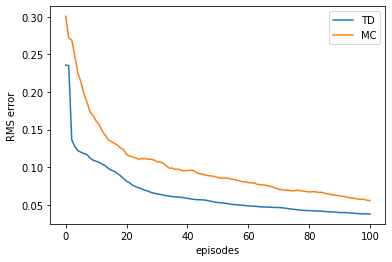

In [12]:
episodes = 100 + 1
td_errors = batch_updating('TD', episodes)
mc_errors = batch_updating('MC', episodes)

plt.plot(td_errors, label='TD')
plt.plot(mc_errors, label='MC')
plt.xlabel('episodes')
plt.ylabel('RMS error')
plt.legend()
plt.show()